In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from collections import OrderedDict
import gc
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import Any

import torch
from torch import nn
from torch.nn import functional as F

from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = './CrossEncoderModel'

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model  = AutoModel.from_pretrained('intfloat/multilingual-e5-base')
                                                # trust_remote_code=True, attn_implementation='sdpa')
        self.tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-base', use_fast=True)
        n_dim = 768
        self.cls = nn.Sequential(OrderedDict(
                                              [
                                                ('dropout', torch.nn.Dropout(.0)),

                                                ('fc_1' , nn.Linear(n_dim, n_dim)),
                                                ('relu_1' , nn.GELU()),
                                                ('layernorm_1' , nn.LayerNorm(n_dim, eps=1e-12)),

                                                ('fc_2' , nn.Linear(n_dim, n_dim)),
                                                ('relu_2' , nn.GELU()),
                                                ('layernorm_2' , nn.LayerNorm(n_dim, eps=1e-12)),

                                                ('fc_3' , nn.Linear(n_dim, 2, bias=False)),
                                              ]
                                ))
    def forward(self, text):
        token = self.tokenizer(text, return_tensors='pt', padding='max_length', 
                               truncation=True, max_length=512, add_special_tokens=True).to(device)
        model_output = self.model(**token)
        result = self.cls(model_output.pooler_output) ####### .pooler_output .last_hidden_state
        return result

In [4]:
crop = 3000

df_train = pd.read_csv('train_split_pairs.csv')
df_train['text1'] = df_train['text1'].apply(lambda x: x[:crop])
df_train['text2'] = df_train['text2'].apply(lambda x: x[:crop])

df_val = pd.read_csv('val_split_pairs.csv')
df_val['text1'] = df_val['text1'].apply(lambda x: x[:crop])
df_val['text2'] = df_val['text2'].apply(lambda x: x[:crop])

df_train = df_train.sample(frac=1).reset_index(drop=True)

In [5]:
def get_batch(df, n):
    result = df.sample(n=n).reset_index(drop=True) 
    texts = result.iloc[:, [0, 1]].sample(frac=1, axis=1).values.tolist()
    targets = result.iloc[:, 2].values.tolist()
    return texts, targets

def estimate_loss():
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        accuracies = torch.zeros(eval_iters)
        for i in range(eval_iters):
            if split == 'train':
                text, target = get_batch(df_train, batch_size)
            else:
                text, target = get_batch(df_val, batch_size)
            loss, accuracy = calculate_loss(text, target)
            losses[i] = loss.item()
            accuracies[i] = accuracy.item()
        out[f'{split}_loss'] = losses.mean().item()
        out[f'{split}_accuracy'] = accuracies.mean().item()
    return out

def calculate_loss(text, target):
    logit = pac.model(text)
    target = torch.tensor(target, dtype=torch.long).to(device)
    loss = F.cross_entropy(logit, target)
    accuracy = sum(logit.to('cpu').argmax(1) == target.to('cpu')) / target.to('cpu').size(0)
    return loss, accuracy

def set_lr(i, optimizer):
    if i < iterations * 0.2:  
        lr = learning_rate * 1e-2
    elif i < iterations * 0.8:  
        lr = learning_rate
    else:
        lr = learning_rate * 1e-1  
    optimizer.param_groups[0]['lr'] = lr
    
def train_model(pac):
    pac.model.train()
    for i in trange(iterations):
        set_lr(i, pac.optimizer)
        text, target = get_batch(df_train, batch_size)
        loss, _ = calculate_loss(text, target)  
        pac.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pac.model.parameters(), max_norm = 1)
        pac.optimizer.step()
        if ((i % eval_interval == 0) or (i == iterations-1)): 
            pac.model.eval()
            with torch.no_grad():
                losses = estimate_loss()
            print(f"step {i}: train loss {losses['train_loss']:.8f}, val loss {losses['val_loss']:.8f} ", end='')
            print(f"train accuracy {losses['train_accuracy']:.0%}, val accuracy {losses['val_accuracy']:.0%}")
            pac.train_loss_history.append(losses['train_loss'])
            pac.val_loss_history.append(losses['val_loss'])
            if losses['val_loss'] < pac.best_val_loss:
                print(f"            saving checkpoint with val loss {losses['val_loss']:.8f}")
                pac.best_val_loss = losses['val_loss']
                checkpoint = {  'model': pac.model.state_dict(),
                                'optimizer': pac.optimizer.state_dict(),
                                'best_val_loss': pac.best_val_loss,
                                'train_loss_history' : pac.train_loss_history,
                                'val_loss_history' : pac.val_loss_history,}
                torch.save(checkpoint, model_path)
            pac.model.train()
    pac.model.eval()
    
def plot_losses(pac):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    smooth = 8 if len(pac.train_loss_history) > 8 else 2
    ax[0].plot(sliding_window_view(pac.train_loss_history, window_shape = smooth).mean(1))
    ax[1].plot(sliding_window_view(pac.val_loss_history, window_shape = smooth).mean(1))
    ax[0].set_title('train_loss_history')
    ax[1].set_title('val_loss_history')
    fig.suptitle('plot losses')
    plt.show()

In [6]:
@dataclass
class ModelPackage:
    model : Any = None
    optimizer : Any = None
    best_val_loss : Any = None
    train_loss_history : Any = None
    val_loss_history : Any = None

In [7]:
base_model = Model().to(device)
torch.nn.init.zeros_(base_model.cls.fc_1.bias)
torch.nn.init.zeros_(base_model.cls.fc_2.bias)
base_optimizer = torch.optim.AdamW(base_model.parameters(), lr=5e-5) 
pac = ModelPackage(model=base_model, optimizer=base_optimizer, best_val_loss=1e+9, train_loss_history=[], val_loss_history=[])  

In [8]:
learning_rate = 9e-5
batch_size = 24
iterations = 1000 
eval_interval = 50
eval_iters = 25

In [9]:
for name, parameter in pac.model.named_parameters():
    if name.startswith('cls'):
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

pac.optimizer.param_groups[0]['weight_decay'] = 0.05
# pac.model.cls[0].p = 0.1

In [10]:
train_model(pac)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

step 0: train loss 0.73033333, val loss 0.75304466 train accuracy 50%, val accuracy 50%
            saving checkpoint with val loss 0.75304466


  5%|████                                                                            | 50/1000 [00:36<05:52,  2.70it/s]

step 50: train loss 0.68916190, val loss 0.67532843 train accuracy 53%, val accuracy 56%
            saving checkpoint with val loss 0.67532843


 10%|███████▊                                                                     | 101/1000 [01:31<1:23:37,  5.58s/it]

step 100: train loss 0.68792635, val loss 0.69640887 train accuracy 54%, val accuracy 49%


 15%|███████████▋                                                                 | 151/1000 [02:07<1:19:06,  5.59s/it]

step 150: train loss 0.68993783, val loss 0.68959594 train accuracy 53%, val accuracy 51%


 20%|███████████████▊                                                               | 200/1000 [02:26<04:59,  2.67it/s]

step 200: train loss 0.68855941, val loss 0.67105544 train accuracy 55%, val accuracy 57%
            saving checkpoint with val loss 0.67105544


 25%|███████████████████▊                                                           | 250/1000 [03:03<04:41,  2.66it/s]

step 250: train loss 0.62589818, val loss 0.64974022 train accuracy 66%, val accuracy 59%
            saving checkpoint with val loss 0.64974022


 30%|███████████████████████▋                                                       | 300/1000 [03:41<04:22,  2.67it/s]

step 300: train loss 0.64111483, val loss 0.62383795 train accuracy 63%, val accuracy 65%
            saving checkpoint with val loss 0.62383795


 35%|███████████████████████████▋                                                   | 350/1000 [04:19<04:05,  2.65it/s]

step 350: train loss 0.62637049, val loss 0.61534995 train accuracy 63%, val accuracy 66%
            saving checkpoint with val loss 0.61534995


 40%|███████████████████████████████▌                                               | 400/1000 [04:56<03:45,  2.66it/s]

step 400: train loss 0.61567199, val loss 0.60583496 train accuracy 66%, val accuracy 70%
            saving checkpoint with val loss 0.60583496


 45%|███████████████████████████████████▋                                           | 451/1000 [05:52<51:29,  5.63s/it]

step 450: train loss 0.92146468, val loss 0.89897978 train accuracy 50%, val accuracy 52%


 50%|███████████████████████████████████████▌                                       | 501/1000 [06:28<46:49,  5.63s/it]

step 500: train loss 0.70181292, val loss 0.70385224 train accuracy 55%, val accuracy 56%


 55%|███████████████████████████████████████████▌                                   | 551/1000 [07:05<42:06,  5.63s/it]

step 550: train loss 0.62510020, val loss 0.65030318 train accuracy 66%, val accuracy 62%


 60%|███████████████████████████████████████████████▍                               | 601/1000 [07:41<37:28,  5.63s/it]

step 600: train loss 0.62531167, val loss 0.63134134 train accuracy 65%, val accuracy 64%


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [08:17<32:46,  5.64s/it]

step 650: train loss 0.62331522, val loss 0.66326272 train accuracy 67%, val accuracy 63%


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [08:54<28:07,  5.64s/it]

step 700: train loss 0.60525054, val loss 0.65227258 train accuracy 67%, val accuracy 63%


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [09:30<23:21,  5.63s/it]

step 750: train loss 0.73117143, val loss 0.80155200 train accuracy 54%, val accuracy 55%


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [10:07<18:41,  5.64s/it]

step 800: train loss 0.61372155, val loss 0.61191893 train accuracy 67%, val accuracy 69%


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [10:43<13:59,  5.63s/it]

step 850: train loss 0.62756479, val loss 0.63910204 train accuracy 67%, val accuracy 64%


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [11:02<00:37,  2.65it/s]

step 900: train loss 0.58737886, val loss 0.57723010 train accuracy 69%, val accuracy 72%
            saving checkpoint with val loss 0.57723010


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [11:57<04:35,  5.63s/it]

step 950: train loss 0.69205266, val loss 0.66273719 train accuracy 59%, val accuracy 66%


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:33<00:00,  1.33it/s]

step 999: train loss 0.61219102, val loss 0.58759725 train accuracy 67%, val accuracy 70%


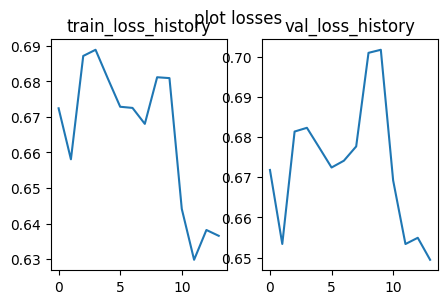

In [11]:
plot_losses(pac)

In [12]:
torch.cuda.empty_cache()

In [14]:
learning_rate = 1e-5
batch_size = 16
iterations = 2000
eval_interval = 50
eval_iters = 25

In [15]:
def load_model_pac(pac, **kwargs):
    if Path(model_path).exists():
        state = torch.load(model_path, **kwargs)
        pac.model = Model().to(device)
        pac.model.load_state_dict(state['model'])
        pac.optimizer = torch.optim.AdamW(pac.model.parameters())
        pac.optimizer.load_state_dict(state['optimizer'])
        pac.best_val_loss = state['best_val_loss']
        pac.train_loss_history = state['train_loss_history']
        pac.val_loss_history = state['val_loss_history']
    else:
        print('WARNING!!! no file to get model. pac is returned without changes')
        
load_model_pac(pac)

In [16]:
for name, parameter in pac.model.named_parameters():
    parameter.requires_grad = True

pac.optimizer.param_groups[0]['weight_decay'] = 0.03
pac.model.cls[0].p = 0.2

In [17]:
train_model(pac)

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

step 0: train loss 0.58010924, val loss 0.56952995 train accuracy 71%, val accuracy 69%
            saving checkpoint with val loss 0.56952995


  3%|█▉                                                                            | 51/2000 [01:02<2:19:38,  4.30s/it]

step 50: train loss 0.58751017, val loss 0.60497022 train accuracy 68%, val accuracy 69%


  5%|███▉                                                                         | 101/2000 [01:48<2:16:16,  4.31s/it]

step 100: train loss 0.55894846, val loss 0.63604319 train accuracy 70%, val accuracy 66%


  8%|█████▊                                                                       | 151/2000 [02:34<2:12:51,  4.31s/it]

step 150: train loss 0.59483236, val loss 0.61270803 train accuracy 67%, val accuracy 68%


 10%|███████▋                                                                     | 201/2000 [03:19<2:09:27,  4.32s/it]

step 200: train loss 0.59783953, val loss 0.61999965 train accuracy 70%, val accuracy 69%


 13%|█████████▋                                                                   | 251/2000 [04:05<2:05:50,  4.32s/it]

step 250: train loss 0.54640061, val loss 0.59914541 train accuracy 72%, val accuracy 67%


 15%|███████████▌                                                                 | 301/2000 [04:51<2:02:14,  4.32s/it]

step 300: train loss 0.56110936, val loss 0.60673910 train accuracy 70%, val accuracy 69%


 18%|█████████████▌                                                               | 351/2000 [05:37<1:58:34,  4.31s/it]

step 350: train loss 0.58060217, val loss 0.61504251 train accuracy 69%, val accuracy 67%


 20%|███████████████▍                                                             | 401/2000 [06:23<1:55:15,  4.32s/it]

step 400: train loss 0.56482172, val loss 0.60311705 train accuracy 73%, val accuracy 69%


 23%|█████████████████▎                                                           | 451/2000 [07:09<1:51:27,  4.32s/it]

step 450: train loss 0.75990862, val loss 0.61385989 train accuracy 65%, val accuracy 68%


 25%|███████████████████▎                                                         | 501/2000 [07:55<1:48:03,  4.32s/it]

step 500: train loss 0.69626909, val loss 0.71875501 train accuracy 67%, val accuracy 65%


 28%|█████████████████████▏                                                       | 551/2000 [08:41<1:44:20,  4.32s/it]

step 550: train loss 0.68147069, val loss 0.57362491 train accuracy 67%, val accuracy 75%


 30%|███████████████████████▏                                                     | 601/2000 [09:27<1:40:40,  4.32s/it]

step 600: train loss 0.59285891, val loss 0.59571338 train accuracy 71%, val accuracy 68%


 33%|█████████████████████████                                                    | 651/2000 [10:13<1:37:09,  4.32s/it]

step 650: train loss 0.57958406, val loss 0.58005708 train accuracy 70%, val accuracy 71%


 35%|██████████████████████████▉                                                  | 701/2000 [10:59<1:33:32,  4.32s/it]

step 700: train loss 0.70879287, val loss 0.66839433 train accuracy 69%, val accuracy 68%


 38%|████████████████████████████▉                                                | 751/2000 [11:45<1:29:57,  4.32s/it]

step 750: train loss 0.64693570, val loss 0.68754548 train accuracy 69%, val accuracy 65%


 40%|██████████████████████████████▊                                              | 801/2000 [12:31<1:26:28,  4.33s/it]

step 800: train loss 0.57109612, val loss 0.61107844 train accuracy 74%, val accuracy 72%


 42%|█████████████████████████████████▌                                             | 850/2000 [13:04<13:08,  1.46it/s]

step 850: train loss 0.50254309, val loss 0.50079936 train accuracy 75%, val accuracy 77%
            saving checkpoint with val loss 0.50079936


 45%|██████████████████████████████████▋                                          | 901/2000 [14:07<1:18:59,  4.31s/it]

step 900: train loss 0.49259782, val loss 0.56170321 train accuracy 76%, val accuracy 77%


 48%|████████████████████████████████████▌                                        | 951/2000 [14:53<1:15:29,  4.32s/it]

step 950: train loss 0.50561613, val loss 0.52400434 train accuracy 80%, val accuracy 80%


 50%|██████████████████████████████████████                                      | 1001/2000 [15:39<1:11:59,  4.32s/it]

step 1000: train loss 0.46303481, val loss 0.59335792 train accuracy 80%, val accuracy 77%


 52%|████████████████████████████████████████▉                                     | 1050/2000 [16:12<10:51,  1.46it/s]

step 1050: train loss 0.51231760, val loss 0.49784201 train accuracy 78%, val accuracy 79%
            saving checkpoint with val loss 0.49784201


 55%|█████████████████████████████████████████▊                                  | 1101/2000 [17:15<1:04:43,  4.32s/it]

step 1100: train loss 0.30648673, val loss 0.58460408 train accuracy 88%, val accuracy 79%


 58%|███████████████████████████████████████████▋                                | 1151/2000 [18:01<1:01:09,  4.32s/it]

step 1150: train loss 0.37866977, val loss 0.51744539 train accuracy 82%, val accuracy 79%


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [18:34<09:07,  1.46it/s]

step 1200: train loss 0.38387707, val loss 0.47386059 train accuracy 84%, val accuracy 81%
            saving checkpoint with val loss 0.47386059


 63%|████████████████████████████████████████████████▊                             | 1251/2000 [19:37<53:53,  4.32s/it]

step 1250: train loss 0.64392990, val loss 0.56597626 train accuracy 75%, val accuracy 77%


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [20:10<07:58,  1.46it/s]

step 1300: train loss 0.34263185, val loss 0.45964414 train accuracy 85%, val accuracy 81%
            saving checkpoint with val loss 0.45964414


 68%|████████████████████████████████████████████████████▋                         | 1351/2000 [21:13<46:41,  4.32s/it]

step 1350: train loss 0.31446016, val loss 0.58274233 train accuracy 86%, val accuracy 77%


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [21:59<43:07,  4.32s/it]

step 1400: train loss 0.37275100, val loss 0.55557847 train accuracy 85%, val accuracy 80%


 73%|████████████████████████████████████████████████████████▌                     | 1451/2000 [22:45<39:29,  4.32s/it]

step 1450: train loss 0.44623539, val loss 0.53051847 train accuracy 82%, val accuracy 80%


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [23:30<35:55,  4.32s/it]

step 1500: train loss 0.30849522, val loss 0.71081424 train accuracy 88%, val accuracy 78%


 78%|████████████████████████████████████████████████████████████▍                 | 1550/2000 [24:04<05:08,  1.46it/s]

step 1550: train loss 0.57272810, val loss 0.45619422 train accuracy 79%, val accuracy 83%
            saving checkpoint with val loss 0.45619422


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [25:06<28:42,  4.32s/it]

step 1600: train loss 0.51539350, val loss 0.54059362 train accuracy 81%, val accuracy 81%


 83%|████████████████████████████████████████████████████████████████▍             | 1651/2000 [25:52<25:09,  4.33s/it]

step 1650: train loss 0.29810035, val loss 0.52434778 train accuracy 89%, val accuracy 80%


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [26:38<21:32,  4.32s/it]

step 1700: train loss 0.30862907, val loss 0.50080764 train accuracy 90%, val accuracy 82%


 88%|████████████████████████████████████████████████████████████████████▎         | 1751/2000 [27:24<17:57,  4.33s/it]

step 1750: train loss 0.32840043, val loss 0.63577408 train accuracy 88%, val accuracy 82%


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [28:10<14:20,  4.33s/it]

step 1800: train loss 0.38359654, val loss 0.61740142 train accuracy 85%, val accuracy 83%


 93%|████████████████████████████████████████████████████████████████████████▏     | 1851/2000 [28:56<10:44,  4.33s/it]

step 1850: train loss 0.32364574, val loss 0.62350547 train accuracy 87%, val accuracy 79%


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [29:42<07:08,  4.32s/it]

step 1900: train loss 0.35193598, val loss 0.71857589 train accuracy 86%, val accuracy 78%


 98%|████████████████████████████████████████████████████████████████████████████  | 1951/2000 [30:28<03:31,  4.32s/it]

step 1950: train loss 0.32580760, val loss 0.59147871 train accuracy 89%, val accuracy 81%


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [31:13<00:00,  1.07it/s]

step 1999: train loss 0.26391208, val loss 0.58134538 train accuracy 90%, val accuracy 82%


In [18]:
torch.cuda.empty_cache()

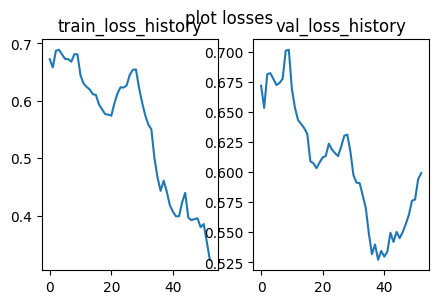

In [19]:
plot_losses(pac)

In [20]:
load_model_pac(pac)

In [21]:
title_data = pd.read_csv('pars.csv')
train_groups = pd.read_csv('train_groups.csv')
test = train_groups.merge(title_data, on='doc_id')
test = test[['pair_id', 'group_id', 'doc_id', 'target', 'all_text']]
test = test.dropna(subset='all_text')
test = test[test['group_id'].isin([81, 115,  92,  14,  33,  48,   6, 124,  84,  20, 126,   4,  61, 75,  55])]
test = test.reset_index(drop=True)
test = test.assign(pred = 0)
test['all_text'] = test['all_text'].apply(lambda x: x[:crop])

In [22]:
pac.model.eval()
val_preds = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    comps = test[(test.group_id==row.group_id) & (test.doc_id != row.doc_id)]
    comps = comps.all_text.values.reshape(1, -1)
    pairs = np.concatenate((np.tile(row.all_text, comps.shape), comps), axis=0).T
    pairs_b = np.array_split(pairs, max(1, pairs.shape[0]//7))
    preds = []
    with torch.no_grad():
        for pair in pairs_b:
            preds += list(map(int, pac.model(pair.tolist()).argmax(1).detach().cpu()))
    val_preds.append(preds)

100%|██████████████████████████████████████████████████████████████████████████████| 1361/1361 [32:14<00:00,  1.42s/it]


In [27]:
from sklearn.metrics import f1_score

pred = [(np.argmax(np.bincount(preds))+1)%2 for preds in val_preds]
print(f1_score(test.target, pred))
q = []
for i in np.arange(1, 100)/100:
    pred = [int(preds.count(1) < len(preds)*i) for preds in val_preds]
    q.append([f1_score(test.target, pred), i])
top = max(q, key=lambda x: x[0])[1]
q 

0.7899891186071817


[[0.13438735177865613, 0.01],
 [0.2430939226519337, 0.02],
 [0.31338028169014087, 0.03],
 [0.37099494097807756, 0.04],
 [0.42857142857142855, 0.05],
 [0.47368421052631576, 0.06],
 [0.4977238239757208, 0.07],
 [0.5295857988165681, 0.08],
 [0.5681492109038737, 0.09],
 [0.5835694050991501, 0.1],
 [0.6132596685082873, 0.11],
 [0.6277173913043478, 0.12],
 [0.644474034620506, 0.13],
 [0.6579292267365662, 0.14],
 [0.6658064516129032, 0.15],
 [0.6785714285714286, 0.16],
 [0.691046658259773, 0.17],
 [0.704119850187266, 0.18],
 [0.7119901112484549, 0.19],
 [0.7167487684729064, 0.2],
 [0.7268292682926829, 0.21],
 [0.7305825242718447, 0.22],
 [0.7373493975903614, 0.23],
 [0.7401197604790419, 0.24],
 [0.7389749702026222, 0.25],
 [0.7434679334916865, 0.26],
 [0.7455621301775148, 0.27],
 [0.7488262910798122, 0.28],
 [0.75, 0.29],
 [0.7517401392111369, 0.3],
 [0.7517401392111369, 0.31],
 [0.7580645161290323, 0.32],
 [0.757192174913694, 0.33],
 [0.757192174913694, 0.34],
 [0.7628865979381443, 0.35],
 [

In [28]:
test_groups = pd.read_csv('test_groups.csv')
test = test_groups.merge(title_data, on='doc_id')
test = test.assign(target = 0)
test = test.dropna(subset='all_text')
test = test.reset_index(drop=True)
test['all_text'] = test['all_text'].apply(lambda x: x[:crop])

In [29]:
torch.cuda.empty_cache()

In [30]:
from tqdm import tqdm

pac.model.eval()
test_preds = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    comps = test[(test.group_id==row.group_id) & (test.doc_id != row.doc_id)]
    comps = comps.all_text.values.reshape(1, -1)
    pairs = np.concatenate((np.tile(row.all_text, comps.shape), comps), axis=0).T
    pairs_b = np.array_split(pairs, max(1, pairs.shape[0]//7))
    preds = []
    with torch.no_grad():
        for pair in pairs_b:
            preds += pac.model(pair.tolist()).argmax(1).detach().cpu()
    test_preds.append(preds)

100%|██████████████████████████████████████████████████████████████████████████| 16624/16624 [6:51:16<00:00,  1.48s/it]


In [69]:
import pickle
with open("test", "wb") as fp:
    pickle.dump(test_preds, fp)

In [72]:
p = 0.55
pred = [int(preds.count(1) < len(preds)*p) for preds in test_preds]
np.bincount(pred)

array([12101,  4523], dtype=int64)

In [73]:
test['pred'] = pred

In [74]:
sub = pd.read_csv('sample_submission.csv', encoding='utf-8')
merged_df = pd.merge(sub, test, on='pair_id', how='left')
merged_df['target'] = merged_df['pred'].fillna(0)
merged_df = merged_df[['pair_id', 'target']]
merged_df.to_csv(f'submission{p}.csv', index=False)